In [1]:
!pip install datasets

In [2]:
# Spotify Tracks Data Analysis and Recommendation Chatbot

# Notebook Sections Overview:
# 1. Import Libraries
# 2. Load Dataset
# 3. Data Exploration & Cleaning
# 4. Feature Analysis & Visualization
# 5. Build Recommendation Model
# 6. Simple Chatbot Interface

In [3]:
# --- 1. IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# --- 2. LOAD DATASET ---
from datasets import load_dataset
spotify_data = load_dataset("maharshipandya/spotify-tracks-dataset")
df = pd.DataFrame(spotify_data['train'])

In [32]:
# --- 3. DATA EXPLORATION & CLEANING ---
# Preview
print(df.head())
print(df.columns)

# Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Convert relevant columns to numeric
numeric_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms', 'popularity']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)
df[['track_genre', 'duration_ms']].dropna()

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


,track_genre,duration_ms
0,acoustic,230666
1,acoustic,149610
2,acoustic,210826
3,acoustic,201933
4,acoustic,198853
...,...,...
113995,world-music,384999
113996,world-music,385000
113997,world-music,271466
113998,world-music,283893


In [112]:
# --- 4. FEATURE ANALYSIS & VISUALIZATION ---
# Basic stats
stats = df[numeric_cols].describe()
print(stats)

# Convert duration to mins and seconds
duration_min = df['duration_ms'] / 60000  # převedeme na minuty
duration_stats = duration_min.describe().round(2)

def min_sec(x):
    minutes = int(x)
    seconds = int(round((x - minutes) * 60))
    return f"{minutes} min {seconds} s"

print("🎵 Duration Statistics (converted to min:sec):\n")
for stat_name in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    value = duration_stats[stat_name]
    print(f"{stat_name.capitalize():<6}: {min_sec(value)}")

        danceability         energy            key       loudness  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        0.566801       0.641383       5.309126      -8.258950   
std         0.173543       0.251530       3.559999       5.029357   
min         0.000000       0.000000       0.000000     -49.531000   
25%         0.456000       0.472000       2.000000     -10.013000   
50%         0.580000       0.685000       5.000000      -7.004000   
75%         0.695000       0.854000       8.000000      -5.003000   
max         0.985000       1.000000      11.000000       4.532000   

                mode    speechiness   acousticness  instrumentalness  \
count  113999.000000  113999.000000  113999.000000     113999.000000   
mean        0.637558       0.084652       0.314907          0.156051   
std         0.480708       0.105733       0.332522          0.309556   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.0000

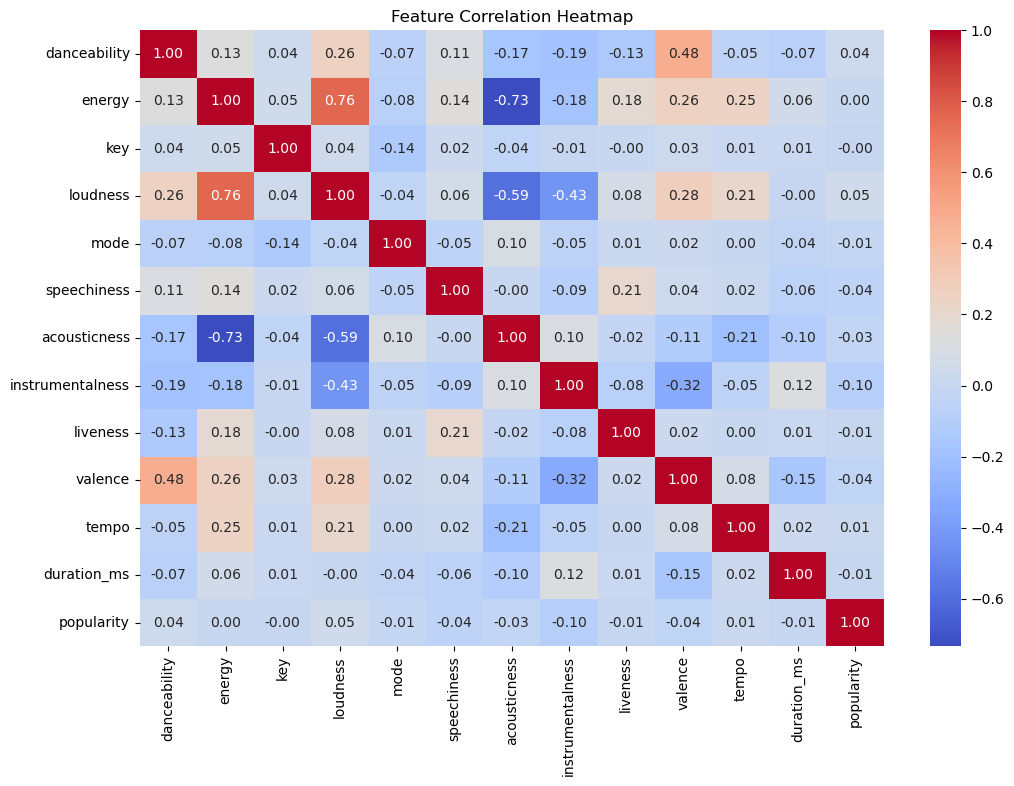

🔍 Correlations with Popularity (from strongest to weakest):

loudness            0.050420
danceability        0.035444
Unnamed: 0          0.032146
time_signature      0.031076
tempo               0.013212
energy              0.001053
key                -0.003847
liveness           -0.005397
duration_ms        -0.007129
mode               -0.013948
acousticness       -0.025458
valence            -0.040522
speechiness        -0.044930
instrumentalness   -0.095147


In [114]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Show what features have the highest correlation with popularity of the track
numeric_df = df.select_dtypes(include='number')

correlations = numeric_df.corr()['popularity'].drop('popularity')
correlations_sorted = correlations.sort_values(ascending=False)

print("🔍 Correlations with Popularity (from strongest to weakest):\n")
print(correlations_sorted.to_string())

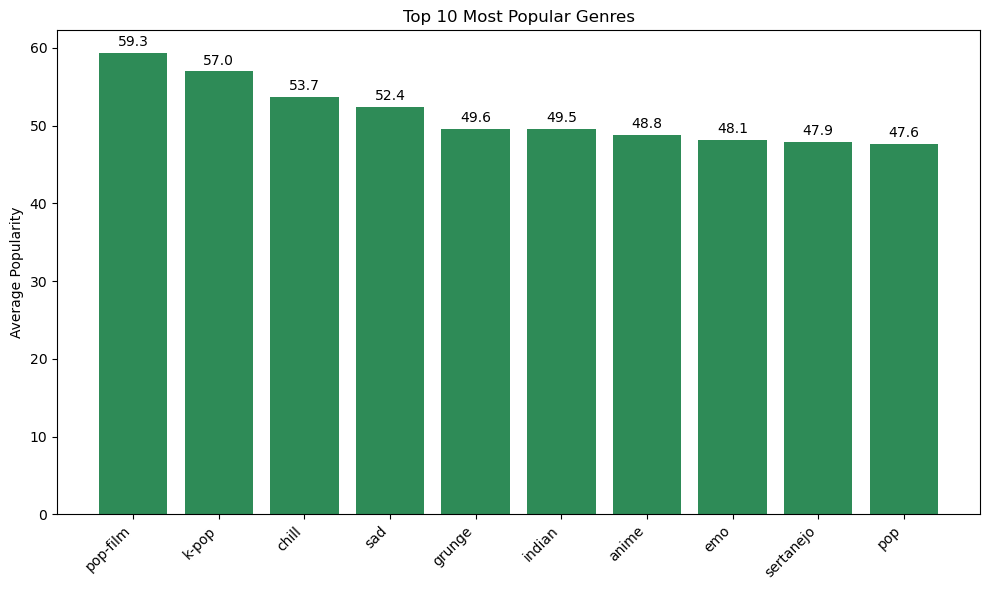

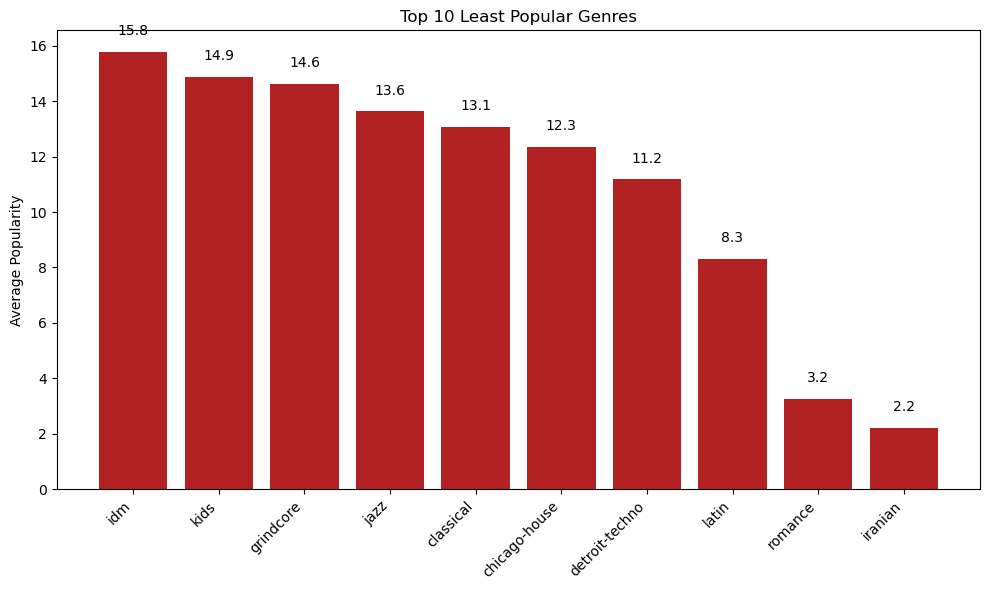

In [66]:
genre_popularity = df.groupby('track_genre')['popularity'].mean()

genre_popularity_sorted = genre_popularity.sort_values(ascending=False)

top_10_genres = genre_popularity_sorted.head(10)
bottom_10_genres = genre_popularity_sorted.tail(10)

# TOP 10
plt.figure(figsize=(10, 6))
bars1 = plt.bar(top_10_genres.index, top_10_genres.values, color='seagreen')
plt.title("Top 10 Most Popular Genres")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45, ha='right')

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Bottom 10
plt.figure(figsize=(10, 6))
bars2 = plt.bar(bottom_10_genres.index, bottom_10_genres.values, color='firebrick')
plt.title("Top 10 Least Popular Genres")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45, ha='right')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

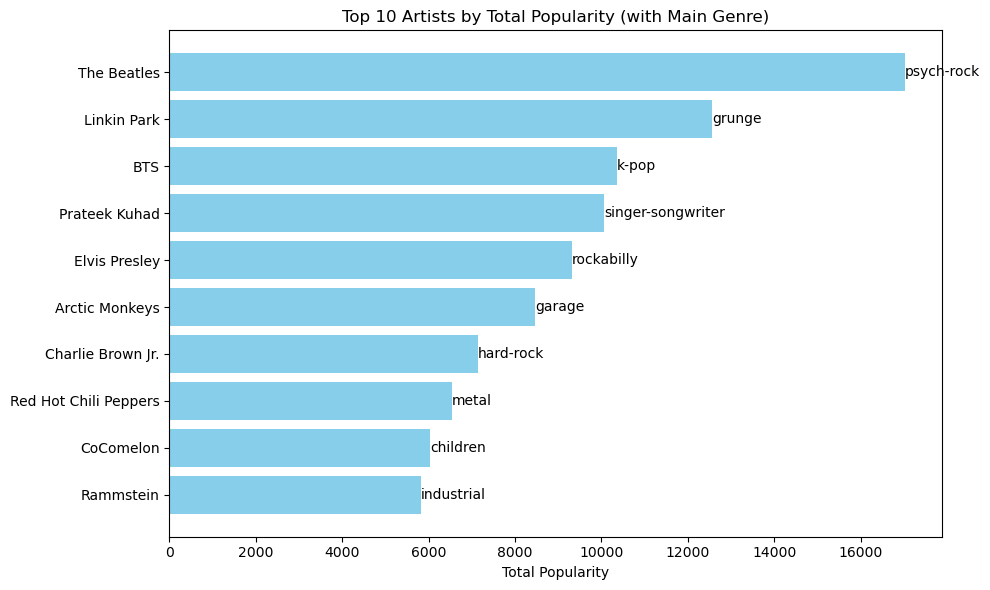

In [40]:
# Get artists popularity and select TOP 10, together with their corresponding genre
artist_popularity = df.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(10)
top_artists = artist_popularity.index

artist_genres = df[df['artists'].isin(top_artists)].groupby('artists')['track_genre'] \
                   .agg(lambda x: x.value_counts().idxmax())

artist_summary = pd.DataFrame({
    'total_popularity': artist_popularity,
    'main_genre': artist_genres
}).reset_index()

artist_summary = artist_summary.sort_values(by='total_popularity', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(artist_summary['artists'], artist_summary['total_popularity'], color='skyblue')
plt.xlabel("Total Popularity")
plt.title("Top 10 Artists by Total Popularity (with Main Genre)")
plt.gca().invert_yaxis()  

# Add text for each genre
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
             f"{artist_summary['main_genre'].iloc[i]}", va='center')

plt.tight_layout()
plt.show()

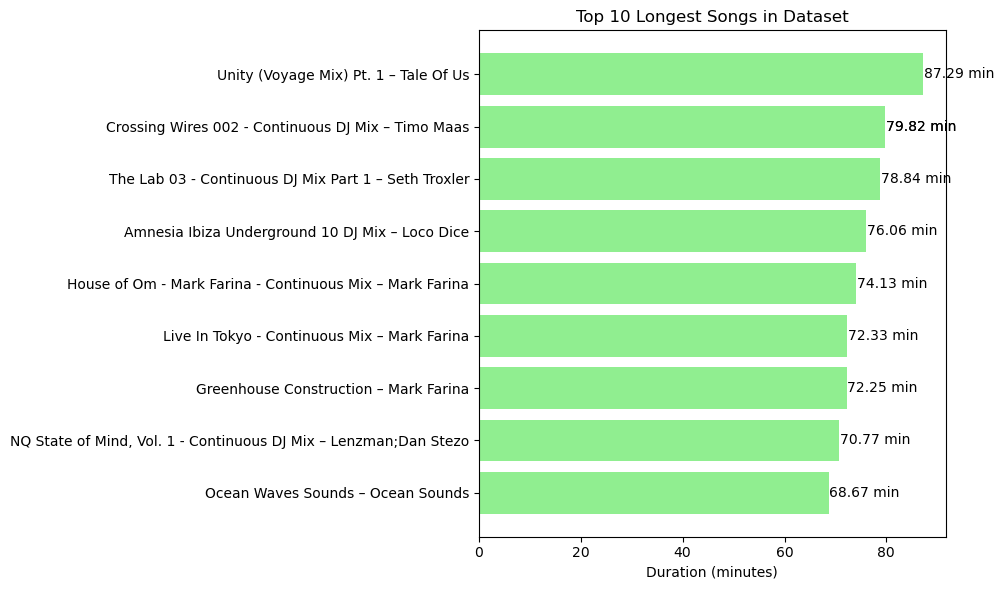

In [42]:
# Get TOP 10 longest tracks by duration in minutes and seconds
top_tracks = df[['track_name', 'artists', 'duration_ms']].dropna()
top_tracks = top_tracks.sort_values(by='duration_ms', ascending=False).head(10)

top_tracks['duration_min'] = top_tracks['duration_ms'] / 60000

top_tracks['label'] = top_tracks['track_name'] + " – " + top_tracks['artists']

plt.figure(figsize=(10, 6))
bars = plt.barh(top_tracks['label'], top_tracks['duration_min'], color='lightgreen')
plt.xlabel("Duration (minutes)")
plt.title("Top 10 Longest Songs in Dataset")
plt.gca().invert_yaxis()  # nejdelší skladba nahoře

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             f"{top_tracks['duration_min'].iloc[i]:.2f} min", va='center')

plt.tight_layout()
plt.show()

In [54]:
# Get top 10 genres with longest and shortest tracks
genre_duration = df.groupby('track_genre')['duration_ms'].mean().sort_values(ascending=False)

def format_duration(ms):
    total_seconds = int(ms // 1000)
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    return f"{minutes}min {seconds}s"

duration_formatted = genre_duration.apply(format_duration)

duration_table = pd.DataFrame({
    'Genre': genre_duration.index,
    'Average Duration': duration_formatted,
    'Duration_ms': genre_duration.values
}).sort_values(by='Duration_ms', ascending=False).reset_index(drop=True)

top_10_longest = duration_table.head(10)
top_10_shortest = duration_table.tail(10)

print("🎵 Top 10 Longest Genres by Average Duration:\n")
print(top_10_longest[['Genre', 'Average Duration']].to_string(index=False))

print("\n🎵 Top 10 Shortest Genres by Average Duration:\n")
print(top_10_shortest[['Genre', 'Average Duration']].to_string(index=False))

🎵 Top 10 Longest Genres by Average Duration:

         Genre Average Duration
detroit-techno         6min 12s
minimal-techno          6min 8s
 chicago-house          6min 6s
     breakbeat         5min 21s
       iranian         5min 19s
        gospel         5min 13s
        techno         5min 12s
   black-metal         5min 11s
       new-age         4min 59s
   world-music         4min 57s

🎵 Top 10 Shortest Genres by Average Duration:

      Genre Average Duration
rock-n-roll         2min 53s
 rockabilly         2min 52s
      chill         2min 49s
 honky-tonk         2min 42s
       kids         2min 36s
     disney         2min 36s
        sad         2min 33s
      study         2min 21s
   children         2min 18s
  grindcore         2min 13s


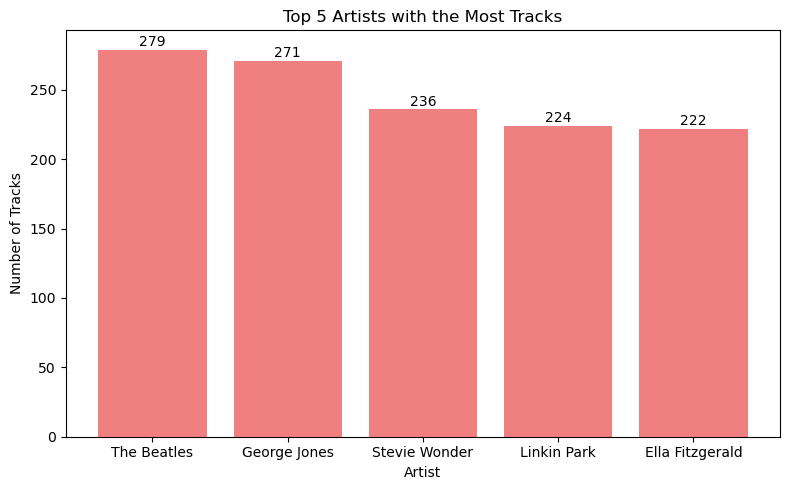

In [58]:
# Get TOP 5 artists with most tracks
artist_counts = df['artists'].value_counts().head(5)

top_artists_df = artist_counts.reset_index()
top_artists_df.columns = ['Artist', 'Number of Tracks']

plt.figure(figsize=(8, 5))
bars = plt.bar(top_artists_df['Artist'], top_artists_df['Number of Tracks'], color='lightcoral')
plt.xlabel("Artist")
plt.ylabel("Number of Tracks")
plt.title("Top 5 Artists with the Most Tracks")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [94]:
# --- 5. BUILD RECOMMENDATION MODEL ---

# Select important features
features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'liveness']
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
feature_names = features 

# Function to get recommendations
def recommend_songs(mood_vector, top_pool=50, select_n=5):
    # Convert mood_vector to DataFrame
    mood_df = pd.DataFrame([mood_vector], columns=feature_names)
    scaled_mood = scaler.transform(mood_df)

    sims = cosine_similarity(scaled_mood, X)

    # Get wider set of tracks with highest similarity
    top_indices = np.argsort(sims[0])[::-1][:top_pool]

    # Randomly pick tracks from this set
    selected_indices = np.random.choice(top_indices, size=min(select_n, len(top_indices)), replace=False)

    return df.iloc[selected_indices][['track_name', 'artists', 'track_genre', 'popularity']]

In [130]:
# --- 6. SIMPLE CHATBOT INTERFACE ---
def chatbot_input():
    print("🎧 Welcome to Moodify! Describe your mood and we'll recommend songs.")
    mood = input("Mood? (happy/sad/energetic/chill): ").strip().lower()

    # Mood presets = [danceability, energy, valence, tempo, acousticness, speechiness]
    presets = {
        "happy":     [0.8, 0.8, 0.9, 120, 0.1, 0.2],
        "sad":       [0.3, 0.2, 0.1, 70,  0.5, 0.3],
        "energetic": [0.9, 1.0, 0.8, 140, 0.05, 0.5],
        "chill":     [0.4, 0.4, 0.6, 90,  0.6, 0.1],
    }

    if mood in presets:
        print(f"\n🎵 Recommendations for mood: {mood.capitalize()}\n")
        print(recommend_songs(presets[mood]))
    else:
        print("❗ Mood not recognized. Try: happy, sad, energetic, chill.")

# --- Example run ---
chatbot_input()


🎧 Welcome to Moodify! Describe your mood and we'll recommend songs.


Mood? (happy/sad/energetic/chill):  chill



🎵 Recommendations for mood: Chill

                                               track_name  \
84219                                            Sevgilim   
52638    I Dreamed About Mama Last Night - Single Version   
16247   21 Hungarian Dances, WoO 1: No. 5 in G Minor: ...   
108685                                   Caserón De Tejas   
90667                                       Kentucky Rain   

                                                  artists  track_genre  \
84219                                        Mavi Işıklar   psych-rock   
52638                                       Hank Williams   honky-tonk   
16247   Johannes Brahms;Wiener Philharmoniker;Claudio ...    classical   
108685                                        Maria Graña        tango   
90667                                       Elvis Presley  rock-n-roll   

        popularity  
84219           39  
52638           11  
16247            0  
108685          18  
90667           29  
